In [4]:
import os
import sys
from time import time 
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

import sys
sys.path.append(r'C:\Users\Christoph\Documents\PublicRepos\DOPER')

# Configuration

In [5]:
# Configuration (environment)
#root_dir = '/home/christoph/Documents/SmartInverter/smartinverter_optimization'
#system = 'Linux64'
root_dir = r'C:\Users\Christoph\Documents\SmartInverter\smartinverter_optimization'
#root_dir = r'C:\Users\Christoph\Desktop'
system = 'Windows64'
#system = 'Windows32'

# Configuration (optimization)
#solver = 'ipopt'

# Variables and Parameter
#solver_dir = os.path.join('SlowActing','Solvers')
solver_dir = 'Solvers'
#solver_path = os.path.join(root_dir, solver_dir, system, solver)

def get_solver(solver):
    if system[0:7] == 'Windows': return os.path.join(solver_dir, system, solver+'.exe')
    else: return os.path.join(root_dir, solver_dir, system, solver)

# DOPER Package

### Utility Module

#!/usr/bin/env python
'''
    INTERNAL USE ONLY
    Utility Module of DOPER package (v1.0)
    cgehbauer@lbl.gov

    Version info (v1.0):
        -) Initial disaggregation of old code.
'''

def pandas_to_dict(df, columns=None):
    '''
        Utility function to translate a pandas dataframe in a Python dictionary.

        Input
        -----
            df (pandas.Series): The series to be converted.

        Returns
        -------
            d (dict): Python dictionary with the series input.
    '''
    d = {}
    if isinstance(df, pd.DataFrame):
        df = df.copy(deep=True)
        if columns: df.columns = columns
        for c in df.columns:
            for k,v in df[c].iteritems():
                d[k,c] = int(v) if v % 1 == 0 else float(v)
    elif isinstance(df, pd.Series):
        for k,v in df.iteritems():
            d[k] = int(v) if v % 1 == 0 else float(v)
    else:
        print('The data must be a pd.DataFrame (for multiindex) or pd.Series (single index).')
    return d

def pyomo_read_parameter(temp):
    '''
        Utility to read pyomo objects and return the content.

        Input
        -----
            temp (pyomo.core.base.param.IndexedParam): The object ot be parsed.
            
        Returns
        -------
            d (dict): The parsed data as dictionary.

    '''
    d = {}
    for k,v in zip(temp.keys(), temp.values()):
        d[k] = v
    return d

In [6]:
from DOPER.utility import pandas_to_dict, pyomo_read_parameter, get_solver

In [7]:
get_solver('cbc', solver_dir=solver_dir)

'Solvers\\Windows64\\cbc.exe'

### Optimization Module

#!/usr/bin/env python
'''
    INTERNAL USE ONLY
    Optimization Module of DOPER package (v1.0)
    cgehbauer@lbl.gov

    Version info (v1.0):
        -) Initial disaggregation of old code.
'''

class DOPER(object):
    def __init__(self, model=None, parameter=None, solver_path='ipopt', pyomo_to_pandas=None,
                 singnal_handle=False, debug=False):
        '''
            Initialization function of the DOPER package.

            Input
            -----
                model (function): The optimization model as a pyomo.environ.ConcreteModel function.
                parameter (dict): Configuration dictionary for the optimization. (default=None)
                solver_path (str): Full path to the solver. (default='ipopt')
                pyomo_to_pandas (function): The function to convert the model output to a 
                    pandas.DataFrame. (default=None)
                singnal_handle (bool): Flag to turn on the Python signal handling. It is recommended to
                    use False in multiprocessing applications. (default=False)
                debug (bool): Flag to enable debug mode. (default=False)
        '''
        if model:
            if type(model) == type(lambda x:x):
                self.model = model
            else:
                logger.error('The model is a type {%s}, not a type {!s}'.format \
                             (type(pyomo_to_pandas), type(lambda x:x)))
        else:
            logger.error('No model funciton supplied. Please supply a pyomo.environ.ConcreteModel object.')
        self.model_loaded = False
        self.parameter = parameter
        self.solver_path = solver_path
        if pyomo_to_pandas:
            if type(pyomo_to_pandas) == type(lambda x:x):
                self.pyomo_to_pandas = pyomo_to_pandas
            else:
                logger.error('The pyomo_to_pandas is a type {%s}, not a type {!s}'.format \
                             (type(pyomo_to_pandas), type(lambda x:x)))
        else:
            logger.warning('No pyomo_to_pandas function supplied. No output dataframe will be processed.')
            self.pyomo_to_pandas = None
        self.singnal_handle = singnal_handle
        self.debug = debug
        
        self.signal_handling_toggle()
        
    def signal_handling_toggle(self):
        '''
            Toggle the Python signal handling. 
            
            It is recommended to use disable signal handling in multiprocessing applications. But
            this can lead to memory leak and Zombie processes.
        '''
        import pyutilib.subprocess.GlobalData
        pyutilib.subprocess.GlobalData.DEFINE_SIGNAL_HANDLERS_DEFAULT = self.singnal_handle
        
    def initialize_model(self, data):
        '''
            Loads the model with its parameters.
            
            Input
            -----
                data (pandas.DataFrame): The input dataframe for the optimization.
        '''
        self.model = self.model(data, self.parameter)
            
    def do_optimization(self, data, parameter=None, tee=False, options={}):
        '''
            Integrated function to conduct the optimization for control purposes.

            Input
            -----
                data (pandas.DataFrame): The input dataframe for the optimization.
                parameter (dict): Configuration dictionary for the optimization. (default=None)
                tee (bool): Prints the solver output. (default=False)
                options (dict): Options to be set for solver. (default={})

            Returns
            -------
                duration (float): Duration of the optimization.
                objective (float): Value of the objective function.
                df (pandas.DataFrame): The resulting dataframe with the optimization result.
                model (pyomo.environ.ConcreteModel): The optimized model.
                result (pyomo.opt.SolverFactory): The optimization result object.
                termination (str): Termination statement of optimization.
        '''
        if parameter:
            # Update parameter, if supplied
            self.parameter = parameter            
        if not self.model_loaded:
            # Instantiate the model, if not already
            self.initialize_model(data)
        with SolverFactory(self.solver_path) as solver:
            t_start = time()
            for k in options.keys():
                solver.options[k] = options[k]
            result = solver.solve(self.model, load_solutions=False, tee=tee)
            termination = result.solver.termination_condition
            if termination != TerminationCondition.optimal:
                logger.warning('Solver did not report optimality:\n{!s}'.format(result.solver))
            self.model.solutions.load_from(result)
            objective = self.model.objective()
            if self.pyomo_to_pandas:
                df = self.pyomo_to_pandas(self.model, self.parameter)
            else:
                df = pd.DataFrame()

        return [time()-t_start, objective, df, self.model, result, termination]

In [8]:
from DOPER.wrapper import DOPER

### Optimization Model

In [143]:
#!/usr/bin/env python
'''
    INTERNAL USE ONLY
    Slow Acting Controller for Smart Inverter Project (v3.0)
    cgehbauer@lbl.gov

    Version info (v1):
        -) Parametrized options
        -) revised battery model
        -) includes efficiency for charging and discharging
        -) Regulation bidding with no constraints (to be verified)
    Version info (v2):
        -) Fixed bug when regulation deactivated (for both up and down)
        -) Applied the import limit to the sum of gird import and regulation
        -) Added preset values for demand charge periods and coincident
    Versoin info (v3):
        -) doc strings
        -) shebang string
    Version info (v4):
        -) do_step function for control purposes.
    Version info (v5):
        -) Reformulated as MILP.
    Version info (v6):
        -) Added variale controller timestep (import,export,battery; NO regulation).
        -) No regulation when timestep <> 1hour.       
        -) Support automatic conversion from datetime to UNIX.
        -) Added internal plotting functionality (plot_standard1).   
    Version info (v7):
        -) Added optional tee to output solver results.
        -) Added option to pass solver parameter.
    Version info (v8):
        -) Changed SOC to [1] instead of [kWh].
        -) Added lower and upper SOC bounds.
        -) Added reserved capacity 'battery_reg' with parameter parameter['site']['regulation_reserved'].
    Version info (v9):
        -) Added self-discharge with fixed parameter.
        -) Added self-discharge to output df.
    Version info (v10):
        -) Deactivated battery=0 in last step.
        -) Added flag to define hour grid line plotting.
        -) Added accounting_ts in energy_cost(model) function, which is model.ts[0:-2], not accounting last ts in objective.
        -) Excluded last model.ts step from demand_maximum_periods and demand_maximum_overall.
'''

from pyomo.environ import ConcreteModel, Set, Param, Var, Constraint, Objective, minimize, Binary, Piecewise
import pandas as pd
import matplotlib.pyplot as plt
from time import time 
import numpy as np
import os
import sys

# Define if binaries (Mixed-Integer) variables are used.
use_binary = True

def SmartInverter_model(inputs, parameter):
    '''
        This function sets up the optimization model used for asset control.

        Input
        -----
            inputs (pandas.DataFrame): The input dataframe for the optimization.
            parameter (dict): Configuration dictionary for the optimization.

        Returns
        -------
            model (pyomo.environ.ConcreteModel): The complete model to be optimized.
    '''
    inputs = inputs.copy(deep=True)
    if type(inputs.index[0]) == type(pd.to_datetime(0)):
        inputs.index = inputs.index.astype(int)/1000000000 # Convert datetime to UNIX
        
    model = ConcreteModel()

    # Define Sets
    model.ts = Set(initialize=list(inputs.index.values), ordered=True, doc='timesteps')
    timestep = model.ts[2] - model.ts[1]
    timestep_scale = 3600 / float(timestep)
    model.periods = Set(initialize=parameter['tariff']['energy'].keys(), doc='demand periods')
    model.batteries = Set(initialize=range(parameter['battery']['count']), doc='batteries in the system')
    accounting_ts = [t for t in model.ts][0:-2] # Timestep for accounting (cutoff last timestep)

    # Check parameter inputs
    for m in ['soc_initial','soc_final','soc_min','soc_max']:
        assert len(parameter['battery'][m]) == len(model.batteries), \
            "Parameter {!s} of length {!s} does not match number of batteries ({!s}).".format \
            (m,len(parameter['battery'][m]),len(model.batteries))
    for b in model.batteries:
        assert parameter['battery']['soc_initial'][b] >= parameter['battery']['soc_min'][b], \
            "Battery SOC intial < SOC min for battery {!s}".format(b)
        assert parameter['battery']['soc_final'][b] >= parameter['battery']['soc_min'][b], \
            "Battery SOC final < SOC min for battery {!s}".format(b)
        assert parameter['battery']['soc_initial'][b] <= parameter['battery']['soc_max'][b], \
        "Battery SOC initial > SOC max for battery {!s}".format(b)
        assert parameter['battery']['soc_final'][b] <= parameter['battery']['soc_max'][b], \
            "Battery SOC final > SOC max for battery {!s}".format(b)
    assert not ((timestep_scale != 1) and (parameter['site']['regulation'])), \
        "Regulaiton is only supported for hourly timesteps. Please set parameter['site']['regulation'] = False."
    assert not (parameter['site']['regulation_reserved'] and parameter['site']['regulation']), \
        "Regulaiton is not supported when regulation battery is already reserved. Please disable one of them." 
    
    # Define Parameter
    model.tariff_energy = Param(model.periods, initialize=parameter['tariff']['energy'], \
                                doc='energy tariff [$/kWh]')
    model.tariff_energy_map = Param(model.ts, initialize=pandas_to_dict(inputs['tariff_energy_map']), \
                                    doc='energy period map [periods]') 
    model.tariff_power = Param(model.periods, initialize=parameter['tariff']['demand'], \
                               doc='power tariff [$/kW]')
    model.tariff_power_map = Param(model.ts, initialize=pandas_to_dict(inputs['tariff_power_map']), \
                                   doc='power period map [periods]') 
    model.tariff_energy_export = Param(model.periods, initialize=parameter['tariff']['export'], \
                                       doc='export tariff [$/kWh]')
    model.tariff_energy_export_map = Param(model.ts, initialize=pandas_to_dict(inputs['tariff_energy_export_map']), \
                                           doc='export period map [periods]') 
    model.tariff_regulation_up = Param(model.ts, initialize=pandas_to_dict(inputs['tariff_regup']), \
                                       doc='regulation up price [$/kWh]')
    model.tariff_regulation_dn = Param(model.ts, initialize=pandas_to_dict(inputs['tariff_regdn']), \
                                       doc='regulation dn price [$/kWh]')
    model.demand = Param(model.ts, initialize=pandas_to_dict(inputs['load_demand']), \
                         doc='load demand [kW]')
    model.generation_pv = Param(model.ts, initialize=pandas_to_dict(inputs['generation_pv']), \
                                doc='pv generation [kW]')
    model.demand_periods_preset = Param(model.periods, initialize=parameter['site']['demand_periods_prev'], \
                                        doc='preset demand [kW]')
    model.battery_available = Param(model.ts, model.batteries, \
                                    initialize= \
                                    pandas_to_dict(inputs[['battery_{!s}_avail'.format(b) for b in model.batteries]] ,\
                                                   columns=model.batteries), \
                                    doc='battery available [-]')
    model.battery_demand_ext = Param(model.ts, model.batteries, \
                                     initialize= \
                                     pandas_to_dict(inputs[['battery_{!s}_demand'.format(b) for b in model.batteries]] ,\
                                                    columns=model.batteries), \
                                     doc='battery external demand [kW]')
    model.outside_temperature = Param(model.ts, initialize=pandas_to_dict(inputs['oat']), \
                                      doc='outside air temperature [C]')
    
    # Define Variables
    model.grid_import = Var(model.ts, bounds=(0, parameter['site']['import_max']), doc='limit grid import [kW]')
    model.grid_export = Var(model.ts, bounds=(0, parameter['site']['export_max']), doc='limit grid export [kW]')
    model.demand_charge_periods = Var(model.periods, bounds=(0, None), doc='maximal demand [kW,periods]')
    model.demand_charge_overall = Var(bounds=(0, None), doc='maximal demand [kW]')
    # Battery
    model.sum_battery_charge_grid_power = Var(model.ts, doc='total battery grid charge [kW]')
    model.sum_battery_discharge_grid_power = Var(model.ts, doc='total battery grid discharge [kW]')
    model.sum_battery_energy = Var(model.ts, doc='total battery stored energy [kWh]')    
    model.sum_battery_selfdischarge_power = Var(model.ts, doc='total battery self-discharge [kW]')
    model.sum_battery_charge_power = Var(model.ts, doc='total limit battery charge [kW]')
    model.sum_battery_discharge_power = Var(model.ts, doc='total limit battery discharge [kW]')
    # Degradation
    model.battery_temperature = Var(model.ts, model.batteries, doc='battery temperature [C]')
    model.battery_calendaraging = Var(model.ts, model.batteries, doc='battery calendar aging [%]')
    model.battery_cycleaging = Var(model.ts, model.batteries, doc='battery cycle aging [%]')
    model.battery_degradation = Var(model.ts, model.batteries, doc='battery degradation [%]')
    model.sum_battery_degradation = Var(model.ts, doc='sum of battery degradation [%]')
    model.sum_battery_degradation_battery = Var(model.batteries, doc='battery degradation per battery [%]')
    
    #'''
    # ChrisNEW
    degradation_parameter = {'calendar': {'a0': 25727.068930200516, 'b0': 0.5685204330581881, 'b1': -70.48414456662813}, \
                             'cycle': {'a0': -0.010145570078488129, 'b0': 0.0003138082941656188, \
                                       'b1': 0.0008476522109451572, 'b2': 0.001229871720643372}}
    '''
    #V2GSim (cycle) and Wang/ChrisNEW (calendar)
    degradation_parameter = {'calendar': {'a0': 25727.068930200516, 'b0': 0.5685204330581881, 'b1': -70.48414456662813}, \
                             'cycle': {'a0': 210640.2753759454, 'b0': 0.40269429065813955, \
                                       'b1': 1.1881405336681485, 'b2': -70.2163516693157}}
    '''
    
    def battery_energy_bounds(model, ts, battery):
        return (parameter['battery']['soc_min'][battery]*parameter['battery']['capacity'][battery], \
                parameter['battery']['soc_max'][battery]*parameter['battery']['capacity'][battery])
    model.battery_energy = Var(model.ts, model.batteries, bounds=battery_energy_bounds, \
                               doc='battery stored energy [kWh]')
    def battery_selfdischarge_bounds(model, ts, battery):
        return (0, parameter['battery']['power'][battery])
    model.battery_selfdischarge_power = Var(model.ts, model.batteries, bounds=battery_selfdischarge_bounds, \
                                            doc='battery self-discharge [kW]')
    def battery_power_bounds(model, ts, battery):
        return (0, parameter['battery']['power'][battery])
    model.battery_charge_power = Var(model.ts, model.batteries, bounds=battery_power_bounds, \
                                     doc='limit battery charge [kW]')  
    model.battery_discharge_power = Var(model.ts, model.batteries, bounds=battery_power_bounds, \
                                        doc='limit battery discharge [kW]')    
    model.battery_charge_grid_power = Var(model.ts, model.batteries, \
                                          bounds=(0, None), doc='battery grid side charge [kW]')
    model.battery_discharge_grid_power = Var(model.ts, model.batteries, \
                                             bounds=(0, None), doc='battery grid side discharge [kW]')
    #model.battery_charge_reg_power = Var(model.ts, bounds=(0, 1), doc='battery regulation charge [kW]')
    #model.battery_discharge_reg_power = Var(model.ts, bounds=(0, 1), doc='battery regulation discharge [kW]')
    if parameter['site']['regulation_reserved']:
        model.regulation_up = Param(model.ts, model.batteries, \
                                    initialize=pandas_to_dict(-1*inputs['battery_reg'].mask(inputs['battery_reg']>0,0)), \
                                    doc='battery regulation up preset [kW]')
        model.regulation_dn = Param(model.ts, model.batteries, \
                                    initialize=pandas_to_dict(inputs['battery_reg'].mask(inputs['battery_reg']<0,0)), \
                                    doc='battery regulation dn preset [kW]')        
    else:
        limit_regulation = parameter['site']['import_max'] if parameter['site']['regulation'] else 0
        model.regulation_up = Var(model.ts, model.batteries, bounds=(0, limit_regulation), doc='regulation up [kW]')
        model.regulation_dn = Var(model.ts, model.batteries, bounds=(0, limit_regulation), doc='regulation dn [kW]')
    model.sum_regulation_up = Param(model.ts, \
                                    initialize=pandas_to_dict(-1*inputs['battery_reg'].mask(inputs['battery_reg']>0,0)), \
                                    doc='regulation up preset [kW]')
    model.sum_regulation_dn = Param(model.ts, \
                                    initialize=pandas_to_dict(inputs['battery_reg'].mask(inputs['battery_reg']<0,0)), \
                                    doc='regulation dn preset [kW]')
    
        

    # Initial Conditions
    # fix battery throughput in last step to 0 (deactivated with v10 on 11/3/2018)
    '''
    model.battery_charge_power[model.ts[len(model.ts)]] = 0
    model.battery_charge_power[model.ts[len(model.ts)]].fixed = True
    model.battery_discharge_power[model.ts[len(model.ts)]] = 0
    model.battery_discharge_power[model.ts[len(model.ts)]].fixed = True
    '''
    # fix final state of energy in last step
    for b in model.batteries:
        if parameter['battery']['soc_final'][b]:
            model.battery_energy[model.ts[len(model.ts)], b] = parameter['battery']['soc_final'][b] * \
                                                               parameter['battery']['capacity'][b]
            model.battery_energy[model.ts[len(model.ts)], b].fixed = True

    # Define LINEAR Constraints
    # Overall energy balance
    def energy_balance(model, ts):
        return model.demand[ts] == model.grid_import[ts] - model.sum_battery_charge_grid_power[ts] \
                                   + model.sum_battery_discharge_grid_power[ts] - model.grid_export[ts] \
                                   + model.generation_pv[ts]
    model.constraint_energy_balance = Constraint(model.ts, rule=energy_balance, \
                                                 doc='constraint energy balance')
    # Batteries
    def sum_battery_charge_grid(model, ts):
        return model.sum_battery_charge_grid_power[ts] == sum(model.battery_charge_grid_power[ts, battery] \
                                                              for battery in model.batteries)
    model.constraint_sum_battery_charge_grid = Constraint(model.ts, rule=sum_battery_charge_grid, \
                                                          doc='sum of all battery charging')
    def sum_battery_discharge_grid(model, ts):
        return model.sum_battery_discharge_grid_power[ts] == sum(model.battery_discharge_grid_power[ts, battery] \
                                                                 for battery in model.batteries)
    model.constraint_sum_battery_discharge_grid = Constraint(model.ts, rule=sum_battery_discharge_grid, \
                                                             doc='sum of all battery discharging')
    def sum_battery_energy(model, ts):
        return model.sum_battery_energy[ts] == sum(model.battery_energy[ts, battery] for battery in model.batteries)
    model.constraint_sum_battery_energy = Constraint(model.ts, rule=sum_battery_energy, \
                                                     doc='sum of all battery energy')
    def sum_battery_selfdischarge(model, ts):
        return model.sum_battery_selfdischarge_power[ts] == sum(model.battery_selfdischarge_power[ts, battery] \
                                                                for battery in model.batteries)
    model.constraint_sum_battery_selfdischarge = Constraint(model.ts, rule=sum_battery_selfdischarge, \
                                                            doc='sum of all battery self discharge')
    def sum_battery_charge(model, ts):
        return model.sum_battery_charge_power[ts] == sum(model.battery_charge_power[ts, battery] \
                                                         for battery in model.batteries)
    model.constraint_sum_battery_charge = Constraint(model.ts, rule=sum_battery_charge, \
                                                     doc='sum of all battery charging')
    def sum_battery_discharge(model, ts):
        return model.sum_battery_discharge_power[ts] == sum(model.battery_discharge_power[ts, battery] \
                                                            for battery in model.batteries)
    model.constraint_sum_battery_discharge = Constraint(model.ts, rule=sum_battery_discharge, \
                                                        doc='sum of all battery discharging') 
    def sum_battery_regulation_up(model, ts):
        return model.sum_regulation_up[ts] == sum(model.regulation_up[ts, battery] \
                                                  for battery in model.batteries)
    model.constraint_sum_battery_regulation_up = Constraint(model.ts, rule=sum_battery_regulation_up, \
                                                            doc='sum of all battery regulation up')
    def sum_battery_regulation_dn(model, ts):
        return model.sum_regulation_dn[ts] == sum(model.regulation_dn[ts, battery] \
                                                  for battery in model.batteries)
    model.constraint_sum_battery_regulation_dn = Constraint(model.ts, rule=sum_battery_regulation_dn, \
                                                            doc='sum of all battery regulation dn') 
    def battery_charge_balance(model, ts, battery):
        return model.battery_charge_power[ts, battery] == (model.battery_charge_grid_power[ts, battery] \
                                                           + model.regulation_dn[ts, battery]) \
                                                          * parameter['battery']['efficiency_charging'][battery]
    model.constraint_battery_charge_balance = Constraint(model.ts, model.batteries, rule=battery_charge_balance, \
                                                         doc='constraint battery charging') 
    def battery_discharge_balance(model, ts, battery):
        return model.battery_discharge_power[ts, battery] == (model.battery_discharge_grid_power[ts, battery] \
                                                              + model.regulation_up[ts, battery]) \
                                                             / parameter['battery']['efficiency_discharging'][battery]
    model.constraint_battery_discharge_balance = Constraint(model.ts, model.batteries, rule=battery_discharge_balance, \
                                                            doc='constraint battery discharging') 
    def battery_selfdischarge_balance(model, ts, battery):
        if ts == model.ts[1]:
            return model.battery_selfdischarge_power[ts, battery] == 0
        else:
            return model.battery_selfdischarge_power[ts, battery] == model.battery_energy[ts-timestep, battery] \
                                                                     * parameter['battery']['self_discharging'][battery] \
                                                                     / 24.0 # FIXME!
    model.constraint_battery_selfdischarge_balance = Constraint(model.ts, model.batteries, rule=battery_selfdischarge_balance, \
                                                                doc='constraint battery self-discharging') 
    def battery_energy_balance(model, ts, battery):
        if ts == model.ts[1]: 
            return model.battery_energy[ts, battery] == parameter['battery']['soc_initial'][battery] \
                                                        * parameter['battery']['capacity'][battery]
        else: 
            return model.battery_energy[ts, battery] == model.battery_energy[ts-timestep, battery] \
                                                        + (+ model.battery_charge_power[ts-timestep, battery] \
                                                           - model.battery_discharge_power[ts-timestep, battery] \
                                                           - model.battery_selfdischarge_power[ts, battery] \
                                                           - model.battery_demand_ext[ts-timestep, battery]) \
                                                        / timestep_scale
    model.constraint_battery_energy_balance = Constraint(model.ts, model.batteries, rule=battery_energy_balance, \
                                                         doc='constraint battery energy balance')
    # Battery degradation
    def battery_temperature(model, ts, battery):
        # Validated with RC Model.ipynb
        R = parameter['battery']['thermal_R'][battery]
        C = parameter['battery']['thermal_C'][battery]
        if ts == model.ts[1]:
            return model.battery_temperature[ts, battery] == parameter['battery']['temperature_initial'][battery]
        else:
            Q_ext = model.battery_charge_power[ts, battery] * (1-parameter['battery']['efficiency_charging'][battery]) \
                    + model.battery_discharge_power[ts, battery] * (1-parameter['battery']['efficiency_discharging'][battery])
            Q_ext = Q_ext * 1000 # Convert to W
            T_prev = model.battery_temperature[ts-timestep, battery]
            T_out = model.outside_temperature[ts]
            return model.battery_temperature[ts, battery] == (R*Q_ext + R*C*T_prev/timestep + T_out) / \
                                                             (1 + R*C/timestep)
    model.constraint_battery_temperature = Constraint(model.ts, model.batteries, rule=battery_temperature, \
                                                      doc='calculation of battery temperature')
    def battery_calendaraging(model, ts, battery):
        days = 365
        T = model.battery_temperature[ts, battery]
        return model.battery_calendaraging[ts, battery] == (degradation_parameter['calendar']['a0'] \
                                                            + degradation_parameter['calendar']['b0'] * T \
                                                            + degradation_parameter['calendar']['b1'] * days) \
                                                           / (timestep_scale * 24 * 365) # scale year to 1 ts    
    model.constraint_battery_calendaraging = Constraint(model.ts, model.batteries, rule=battery_calendaraging, \
                                                        doc='calculation of battery calendar aging')
    def battery_cycleaging(model, ts, battery):
        T = model.battery_temperature[ts, battery]
        Vnominal = parameter['battery']['nominal_V'][battery]
        P_kW = model.battery_charge_power[ts, battery] + model.battery_discharge_power[ts, battery]
        C_rate = P_kW / parameter['battery']['capacity'][battery]
        E_Ah = (P_kW * 1) / timestep_scale * 1000 / Vnominal # P -> kWh to Ah
        ''' ATTENTION *0 ATTENTION '''
        return model.battery_cycleaging[ts, battery] == degradation_parameter['cycle']['a0'] * 0\
                                                        + degradation_parameter['cycle']['b0'] * T \
                                                        + degradation_parameter['cycle']['b1'] * C_rate \
                                                        + degradation_parameter['cycle']['b2'] * E_Ah  
    model.constraint_battery_cycleaging = Constraint(model.ts, model.batteries, rule=battery_cycleaging, \
                                                     doc='calculation of battery cycle aging')
    
    print('Cycleaging * 0')
    def battery_degradation(model, ts, battery):
        return model.battery_degradation[ts, battery] == model.battery_calendaraging[ts, battery] \
                                                         + model.battery_cycleaging[ts, battery] * 0
    model.constraint_battery_degradation = Constraint(model.ts, model.batteries, rule=battery_degradation, \
                                                      doc='calculation of total battery degradation')    
    
    def sum_battery_degradation(model, ts):
        return model.sum_battery_degradation[ts] == sum(model.battery_degradation[ts, battery] \
                                                        for battery in model.batteries)
    model.constraint_sum_battery_degradation = Constraint(model.ts, rule=sum_battery_degradation, \
                                                          doc='sum of battery degradation')
    
    def sum_battery_degradation_battery(model, battery):
        return model.sum_battery_degradation_battery[battery] == sum(model.battery_degradation[t, battery] \
                                                                     for t in accounting_ts)
    model.constraint_sum_battery_degradation_battery = Constraint(model.batteries, rule=sum_battery_degradation_battery, \
                                                                  doc='battery degradation per battery calculation')
    
    
    
    
    
    
    
    # Site constraints
    def demand_maximum_periods(model, ts):
        if ts == model.ts[len(model.ts)]: return model.demand_charge_periods[model.tariff_power_map[ts]] >= 0
        else: return model.demand_charge_periods[model.tariff_power_map[ts]] >= model.grid_import[ts] \
                                                                                - model.demand_periods_preset[model.tariff_power_map[ts]]
    model.constraint_demand_maximum = Constraint(model.ts, rule=demand_maximum_periods, doc='constraint demand periods')
    def demand_maximum_overall(model, ts):
        if ts == model.ts[len(model.ts)]: return model.demand_charge_overall >= 0
        else: return model.demand_charge_overall >= model.grid_import[ts] - parameter['site']['demand_coincident_prev']
    model.constraint_demand_overall = Constraint(model.ts, rule=demand_maximum_overall, doc='constraint demand overall')
    def limit_physical_import(model, ts):
        return model.sum_regulation_up[ts] \
               + model.sum_regulation_dn[ts] \
               + model.grid_import[ts] <= parameter['site']['import_max']
    model.constraint_limit_physical_import = Constraint(model.ts, rule=limit_physical_import, \
                                                        doc='constraint grid import limit')

    
    
    # Define BINARY Constraints
    # Battery Charing XOR Discharging
    if use_binary:
        model.battery_chargeXORdischarge = Var(model.ts, model.batteries, domain=Binary, \
                                               doc='battery charge or discharge binary [-]')
        def battery_charge_XOR_discharge(model, ts, battery):
            return model.battery_charge_power[ts, battery] <=  model.battery_chargeXORdischarge[ts, battery] \
                                                               * parameter['battery']['power'][battery] \
                                                               * model.battery_available[ts, battery]
        model.constraint_battery_charge_XOR_discharge = Constraint(model.ts, model.batteries, \
                                                                   rule=battery_charge_XOR_discharge, \
                                                                   doc='constraint battery charging xor discharging')  
        def battery_discharge_XOR_charge(model, ts, battery):
            return model.battery_discharge_power[ts, battery] <=  (1 - model.battery_chargeXORdischarge[ts, battery]) \
                                                                   * parameter['battery']['power'][battery] \
                                                                   * model.battery_available[ts, battery]
        model.constraint_battery_discharge_XOR_charge = Constraint(model.ts, model.batteries, \
                                                                   rule=battery_discharge_XOR_charge, \
                                                                   doc='constraint battery discharging xor charging')  
    else:
        def battery_chargeXORdischarge(model, ts, battery):
            return model.battery_charge_power[ts, battery] * model.battery_discharge_power[ts, battery] <= 0
        model.constraint_battery_chargeXORdischarge = Constraint(model.ts, model.batteries, \
                                                                 rule=battery_chargeXORdischarge, \
                                                                 doc='constraint battery charge or discharge')
    # Regulation Up XOR Dn
    if use_binary:
        model.regulation_upXORdn = Var(model.ts, doc='regulation up xor down binary [-]',  domain=Binary)
        def regulation_up_XOR_dn(model, ts):
            return model.sum_regulation_up[ts] <=  model.regulation_upXORdn[ts] * parameter['site']['import_max']
        model.constraint_regulation_up_XOR_dn = Constraint(model.ts, rule=regulation_up_XOR_dn, \
                                                           doc='constraint regulation up xor down')  
        def regulation_dn_XOR_up(model, ts):
            return model.sum_regulation_dn[ts] <=  (1 - model.regulation_upXORdn[ts]) * parameter['site']['import_max']
        model.constraint_regulation_dn_XOR_up = Constraint(model.ts, rule=regulation_dn_XOR_up, \
                                                           doc='constraint regulation down xor up')  
    else:
        def regulation_upXORdn(model, ts):
            return model.sum_regulation_up[ts] * model.sum_regulation_dn[ts] <= 0
        model.constraint_regulation_upXORdn = Constraint(model.ts, rule=regulation_upXORdn, \
                                                         doc='constraint regulation up or down') 
    # Grid Import XOR Export
    if use_binary:
        model.grid_importXORexport = Var(model.ts, doc='grid import xor export binary [-]',  domain=Binary)
        def grid_import_XOR_export(model, ts):
            return model.grid_import[ts] <=  model.grid_importXORexport[ts] * parameter['site']['import_max']
        model.constraint_grid_import_XOR_export = Constraint(model.ts, rule=grid_import_XOR_export, \
                                                             doc='grid import xor export')  
        def grid_export_XOR_import(model, ts):
            return model.grid_export[ts] <=  (1 - model.grid_importXORexport[ts]) * parameter['site']['import_max']
        model.constraint_grid_export_XOR_import = Constraint(model.ts, rule=grid_export_XOR_import, \
                                                             doc='grid export xor import')  
    else:
        def grid_importXORexport(model, ts):
            return model.grid_export[ts] * model.grid_import[ts] <= 0
        model.constraint_grid_importXORexport = Constraint(model.ts, rule=grid_importXORexport, \
                                                           doc='constraint grid import or export')       
        
        
    # Define Objective
    model.regulation_revenue = Var(model.ts, bounds=(0, None), doc='regulation revenue [$]')
    def regulation_revenue_calculation(model, ts):
        return model.regulation_revenue[ts] == \
                model.sum_regulation_up[ts] * model.tariff_regulation_up[ts] + \
                model.sum_regulation_dn[ts] * model.tariff_regulation_dn[ts]
    model.constraint_regulation_revenue_calculation = Constraint(model.ts, rule=regulation_revenue_calculation, \
                                                                 doc='constraint regulation revenue calculation')
    model.energy_cost = Var(model.ts, bounds=(0, None), doc='energy cost [$]')
    def energy_cost_calculation(model, ts):
        return model.energy_cost[ts] == \
                model.grid_import[ts] * model.tariff_energy[model.tariff_energy_map[ts]] / timestep_scale
    model.constraint_energy_cost_calculation = Constraint(model.ts, rule=energy_cost_calculation, \
                                                          doc='constraint energy cost calculation')
    model.energy_export_revenue = Var(model.ts, bounds=(0, None), doc='energy export revenue [$]')
    def energy_export_revenue_calculation(model, ts):
        return model.energy_export_revenue[ts] == \
                model.grid_export[ts] * model.tariff_energy_export[model.tariff_energy_export_map[ts]] / timestep_scale
    model.constraint_energy_export_revenue_calculation = Constraint(model.ts, rule=energy_export_revenue_calculation, \
                                                                    doc='constraint energy export revenue calculation')
    
    # Cost Module
    model.sum_energy_cost = Var(doc='energy cost [$]')
    model.sum_demand_cost = Var(doc='demand cost [$]')
    model.sum_export_revenue = Var(doc='export energy revenue [$]')
    model.sum_regulation_revenue = Var(doc='regulation revenue [$]')
    model.sum_degradation_cost = Var(doc='battery degradation cost [$]')
    model.total_cost = Var(doc='total energy cost [$]')
    
    def sum_energy_cost(model):
        return model.sum_energy_cost == sum(model.energy_cost[t] for t in accounting_ts)
    model.constraint_sum_energy_cost = Constraint(rule=sum_energy_cost, doc='energy cost calculation')
    
    def sum_demand_cost(model):
        demand = 0
        if parameter['site']['customer'] == 'Commercial':
            demand = sum(model.demand_charge_periods[p] * model.tariff_power[p] for p in model.periods)
            demand += model.demand_charge_overall * parameter['tariff']['demand_coincident']
        return model.sum_demand_cost == demand
    model.constraint_sum_demand_cost = Constraint(rule=sum_demand_cost, doc='demand cost calculation')
    
    def sum_export_revenue(model):
        export = 0
        if parameter['site']['export_max'] > 0:
            export = -1* sum(model.energy_export_revenue[t] for t in accounting_ts)
        return model.sum_export_revenue == export
    model.constraint_sum_export_revenue = Constraint(rule=sum_export_revenue, doc='export revenue calculation')
    
    def sum_regulation_revenue(model):
        regulation = 0
        if parameter['site']['regulation']:
            regulation = -1* sum(model.regulation_revenue[t] for t in accounting_ts)
        return model.sum_regulation_revenue == regulation
    model.constraint_sum_regulation_revenue = Constraint(rule=sum_regulation_revenue, doc='regulation revenue calculation')  
    
    '''
    model.accounting_battery_degradation = Var(model.batteries, doc='accounting battery degradation per battery [%]')
    def accounting_battery_degradation1(model, battery):
        return model.accounting_battery_degradation[battery] >= model.sum_battery_degradation_battery[battery]
    model.constraint_accounting_battery_degradation1 = Constraint(rule=accounting_battery_degradation1, \
                                                                  doc='battery degradation per battery calculation (1)')
    def accounting_battery_degradation2(model, battery):
        return model.accounting_battery_degradation[battery] >= model.sum_battery_degradation_battery[battery]
    model.constraint_accounting_battery_degradation2 = Constraint(rule=accounting_battery_degradation2, \
                                                                  doc='battery degradation per battery calculation (2)')
    '''
    
    def sum_degradation_cost(model):
        cost = 0
        for battery in model.batteries:
            cost += model.sum_battery_degradation_battery[battery] / 100 \
                    * parameter['battery']['degradation_replacementcost'][battery]
        return model.sum_degradation_cost >= cost
    model.constraint_sum_degradation_cost = Constraint(rule=sum_degradation_cost, doc='battery degradation calculation')
        
    def total_cost(model):
        return model.total_cost == model.sum_energy_cost \
                                   + model.sum_demand_cost \
                                   + model.sum_export_revenue \
                                   + model.sum_regulation_revenue
    model.constraint_total_cost = Constraint(rule=total_cost, doc='total cost')
    
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export'] \
               + model.sum_regulation_revenue * parameter['objective']['weight_regulation'] \
               + model.sum_degradation_cost * parameter['objective']['weight_degradation']
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    
    print('Attention, excluded cycle aging model!')
    
    return model      

def pyomo_to_pandas(model, parameter):
    '''
        Utility to translate optimization output to a dataframe.

        Input
        -----
            model (pyomo.environ.ConcreteModel): The optimized model to be translated.
            parameter (dict): Configuration dictionary for the optimization.

        Returns
        -------
            df (pandas.DataFrame): A dataframe including the results of the optimization.
    '''
    columns = ['Battery Power [kW]','Import Power [kW]','Export Power [kW]','Battery Energy [kWh]','Load Power [kW]', \
               'Tariff Energy Period [-]','Tariff Power Period [-]','PV Power [kW]','Battery Self Discharge [kW]', \
               'Temperature [C]','Battery Avilable [-]','Battery External [kW]','Reg Up [kW]','Reg Dn [kW]', \
               'Tariff Reg Up [$/kWh]','Tariff Reg Dn [$/kWh]','Reg Revenue [$]','Energy Cost [$]', \
               'Energy Export Revenue [kW]']
    df = {}
    for t in model.ts:
        df[t] = [model.sum_battery_charge_power[t].value-model.sum_battery_discharge_power[t].value, \
                 model.grid_import[t].value, model.grid_export[t].value, \
                 model.sum_battery_energy[t].value, model.demand[t], model.tariff_energy_map[t], \
                 model.tariff_power_map[t], -1*model.generation_pv[t], model.sum_battery_selfdischarge_power[t].value, \
                 model.outside_temperature[t]]
        # Available
        df[t] += [sum([model.battery_available[t,b] for b in model.batteries])/len(model.batteries)]
        # External Demand
        df[t] += [sum([model.battery_demand_ext[t,b] for b in model.batteries])]
        # Regulation
        df[t] += [model.sum_regulation_up[t], model.sum_regulation_dn[t]]
        # Tariff
        df[t] += [model.tariff_regulation_up[t], model.tariff_regulation_dn[t], model.regulation_revenue[t].value, \
                  model.energy_cost[t].value, model.energy_export_revenue[t].value]
        for b in model.batteries:
            df[t] += [model.battery_charge_power[t,b].value-model.battery_discharge_power[t,b].value, \
                      model.battery_energy[t,b].value, model.battery_available[t,b], model.battery_demand_ext[t,b], \
                      model.battery_temperature[t,b].value,model.battery_degradation[t,b].value, \
                      model.battery_calendaraging[t,b].value,model.battery_cycleaging[t,b].value]
    for b in model.batteries:        
        columns += ['Battery {!s} Power [kW]'.format(b), 'Battery {!s} Energy [kWh]'.format(b), \
                    'Battery {!s} Available [-]'.format(b), 'Battery {!s} External [kW]'.format(b), \
                    'Battery {!s} Temperature [C]'.format(b), 'Battery {!s} Degradation [%]'.format(b), \
                    'Battery {!s} Calendar Aging [%]'.format(b), 'Battery {!s} Cycle Aging [%]'.format(b)]
        
        
    df = pd.DataFrame(df).transpose()
    df.columns = columns
    df.index = pd.to_datetime(df.index, unit='s')
    df['Battery SOC [-]'] = df['Battery Energy [kWh]'] / float(sum(parameter['battery']['capacity']))
    for b in model.batteries:
        df['Battery {!s} SOC [-]'.format(b)] = df['Battery {!s} Energy [kWh]'.format(b)] \
                                               / float(parameter['battery']['capacity'][b])

    df['Tariff Energy [$/kWh]'] = df[['Tariff Energy Period [-]']].replace(pyomo_read_parameter(model.tariff_energy))
    return df
    
def plot_streams(axs, temp, plot_times=False, title=None, ylabel=None, legend=False, loc=1):
    '''
        Utility to simplify plotting of subplots.

        Input
        -----
            axs (matplotlib.axes._subplots.AxesSubplot): The axis to be plotted.
            temp (pandas.Series): The stream to be plotted.
            plot_times (bool): Flag if time separation should be plotted. (default=True)
    '''
    axs.plot(temp)
    axs.legend(temp.columns, loc=2)
    if plot_times:
        idx0 = temp.index[temp.index.minute==0]
        axs.plot([idx0[idx0.hour==8],idx0[idx0.hour==8]],[temp.values.min(),temp.values.max()], color='orange', linestyle=':')
        axs.plot([idx0[idx0.hour==12],idx0[idx0.hour==12]],[temp.values.min(),temp.values.max()], color='red', linestyle=':')
        axs.plot([idx0[idx0.hour==18],idx0[idx0.hour==18]],[temp.values.min(),temp.values.max()], color='red', linestyle=':')
        axs.plot([idx0[idx0.hour==21],idx0[idx0.hour==21]],[temp.values.min(),temp.values.max()], color='orange', linestyle=':')
        if temp.values.min() < 0 and temp.values.max() > 0:
            axs.plot([idx0[0],idx0[-1]],[0,0], color='black', linestyle=':')
    if title: axs.set_title(title)
    if ylabel: axs.set_ylabel(ylabel)
    if legend: axs.legend(legend, loc=loc)
        
def plot_standard1(df, plot=True, plot_times=True, tight=True):
    '''
        A standard plotting template to present results.

        Input
        -----
            df (pandas.DataFrame): The resulting dataframe with the optimization result.
            plot (bool): Flag to plot or return the figure. (default=True)
            plot_times (bool): Flag if time separation should be plotted. (default=True)
            tight (bool): Flag to use tight_layout. (default=True)
            
        Returns
        -------
            None if plot == True.
            else:
                fig (matplotlib figure): Figure of the plot.
                axs (numpy.ndarray of matplotlib.axes._subplots.AxesSubplot): Axis of the plot.
    '''
    fig, axs = plt.subplots(6,1, figsize=(12, 3*5), sharex=True, sharey=False, gridspec_kw = {'width_ratios':[1]})
    axs = axs.ravel()
    plot_streams(axs[0], df[['Import Power [kW]','Export Power [kW]']], plot_times=plot_times)
    plot_streams(axs[1], df[['Battery Power [kW]','Load Power [kW]','PV Power [kW]']], plot_times=plot_times)
    plot_streams(axs[2], df[['Tariff Energy [$/kWh]']], plot_times=plot_times)
    plot_streams(axs[3], df[['Battery SOC [-]']], plot_times=plot_times)
    plot_streams(axs[4], df[['Reg Up [kW]','Reg Dn [kW]']], plot_times=plot_times)
    plot_streams(axs[5], df[['Tariff Reg Up [$/kWh]','Tariff Reg Dn [$/kWh]']], plot_times=plot_times)
    if plot:
        if tight:
            plt.tight_layout()
        plt.show()
    else: return fig, axs
    
def plot_battery1(df, model, plot=True, tight=True):
    '''
        A standard plotting template to present results.

        Input
        -----
            df (pandas.DataFrame): The resulting dataframe with the optimization result.
            plot (bool): Flag to plot or return the figure. (default=True)
            plot_times (bool): Flag if time separation should be plotted. (default=True)
            tight (bool): Flag to use tight_layout. (default=True)
            
        Returns
        -------
            None if plot == True.
            else:
                fig (matplotlib figure): Figure of the plot.
                axs (numpy.ndarray of matplotlib.axes._subplots.AxesSubplot): Axis of the plot.
    '''
    fig, axs = plt.subplots(6,1, figsize=(12, 6*3), sharex=True, sharey=False, gridspec_kw = {'width_ratios':[1]})
    axs = axs.ravel()
    plot_streams(axs[0], df[['Battery Power [kW]','Load Power [kW]','PV Power [kW]']], \
                 title='Overview', ylabel='Power [kW]\n(<0:supply; >0:demand)', \
                 legend=['Battery','Load','PV'])
    plot_streams(axs[1], df[['Battery Power [kW]']+['Battery {!s} Power [kW]'.format(b) for b in model.batteries]], \
                 title='Battery Utilization', ylabel='Power [kW]\n(<0:discharge; >0:charge)', \
                 legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[2], df[['Battery SOC [-]']+['Battery {!s} SOC [-]'.format(b) for b in model.batteries]]*100, \
                 title='Battery State of Charge', ylabel='SOC [%]', \
                 legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[3], df[['Battery Avilable [-]']+['Battery {!s} Available [-]'.format(b) for b in model.batteries]], \
             title='Battery Availability', ylabel='Availability [-]\n(0:False; 1:True)', \
             legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[4], df[['Battery External [kW]']+['Battery {!s} External [kW]'.format(b) for b in model.batteries]], \
             title='Battery External Demand', ylabel='Power [kW]', \
             legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[5], df[['Temperature [C]']+['Battery {!s} Temperature [C]'.format(b) for b in model.batteries]], \
             title='Battery Temperature', ylabel='Temperature [C]', \
             legend=['Outside']+['Battery {!s}'.format(b) for b in model.batteries])
    if plot:
        if tight:
            plt.tight_layout()
        plt.show()
    else: return fig, axs

In [144]:
# TODO
# Filter battery issues in advance (avoid infeasibility); or slack variables
# First controller as charging manager
# Penalize movement
# Todo include end of life (otherwise degradation * cost)
# Cycle aging
# RC parameter
# Better implementation of degradation
# Temperature and degradation also during driving?
# Which scenarios? Regulation and V2B at same time or XOR; Hard in reality, easy in simulation

# Done - Split power battery, external power battery (where to add availability and external demand; battery SOC calculation)
# Done - Battery demand when unplugged
# Done - Split objective and total energy cost (for penalty)
# Done - Battery thermal model
# Done - Battery degradation model

In [145]:
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data, tee=False)
duration, objective, df, model, result, termination = res
print (standard_report(res))

Cycleaging * 0
Attention, excluded cycle aging model!
Solver			CBC
Duration [s]		2.76
Objective [$]		10581.15		3836.32 (Total Cost)
Cost [$]		6771.53 (Energy)	3610.6 (Demand)		199.02 (Degradation)
Revenue [$]		0.0 (Export)		0.0 (Regulation)



In [146]:
# from pyomo.opt import SolverFactory, TerminationCondition
# with SolverFactory(get_solver('cbc', solver_dir=solver_dir)) as solver:
#     t_start = time()
#     solver.options['verbose'] = 1
#     print(solver.options)
#     result = solver.solve(smartDER.model, load_solutions=True, tee=True)
#     termination = result.solver.termination_condition

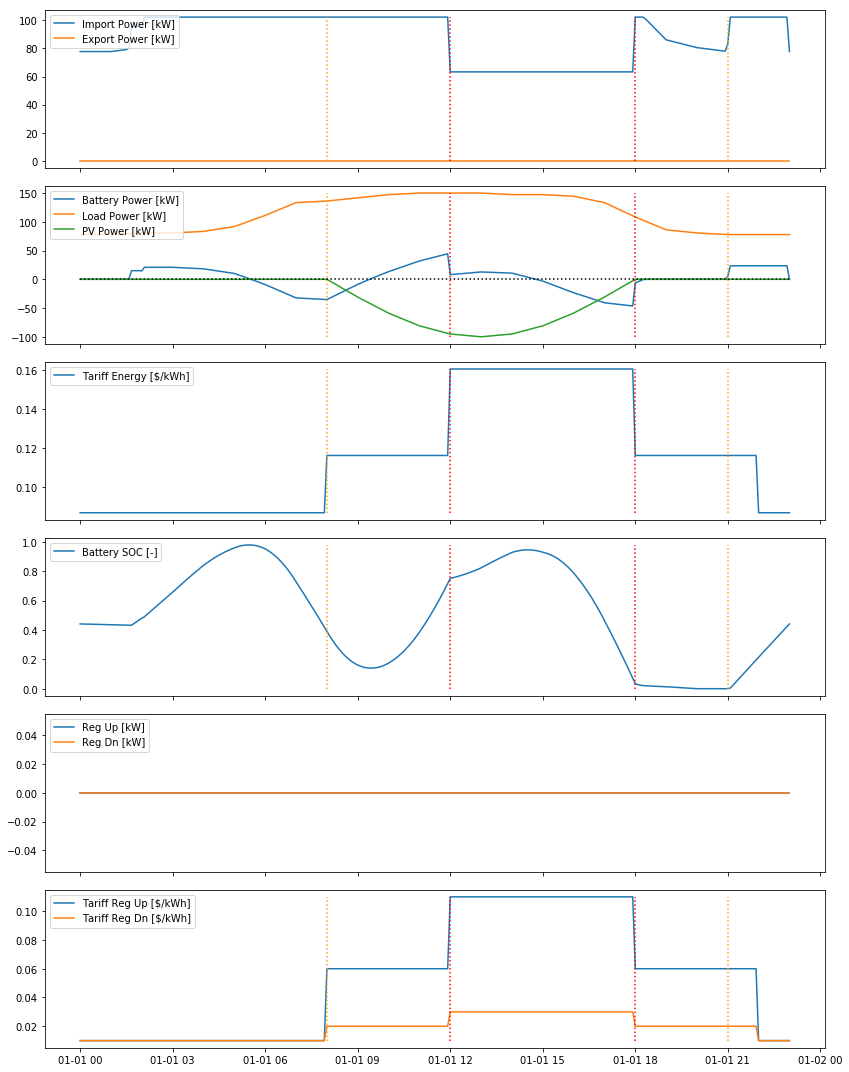

In [147]:
plot_standard1(df)

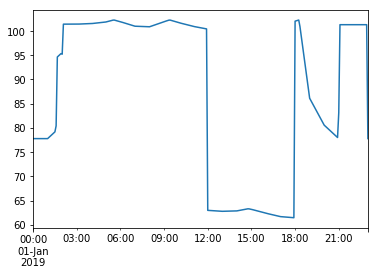

In [148]:
df[['Battery Power [kW]','Load Power [kW]','PV Power [kW]']].sum(axis=1).plot()

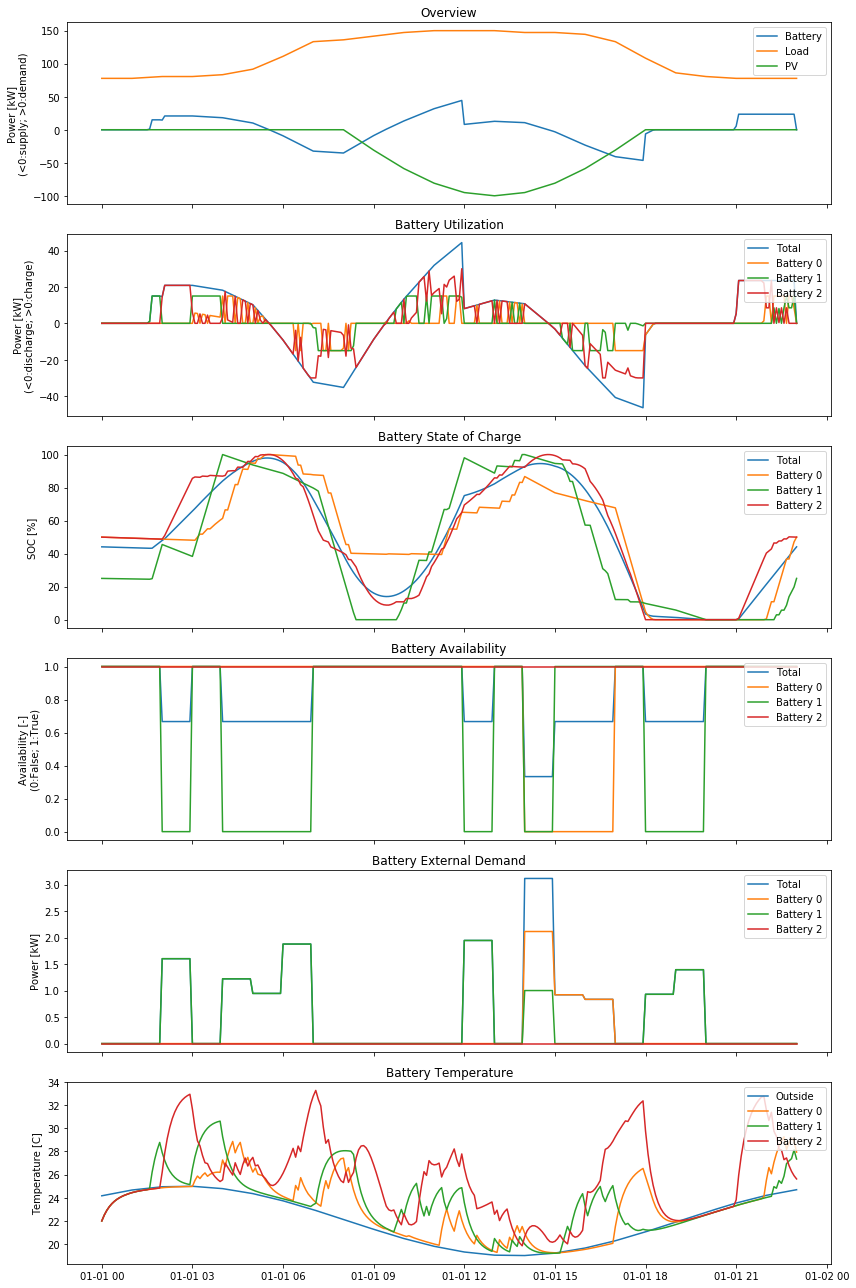

In [149]:
plot_battery1(df, model)

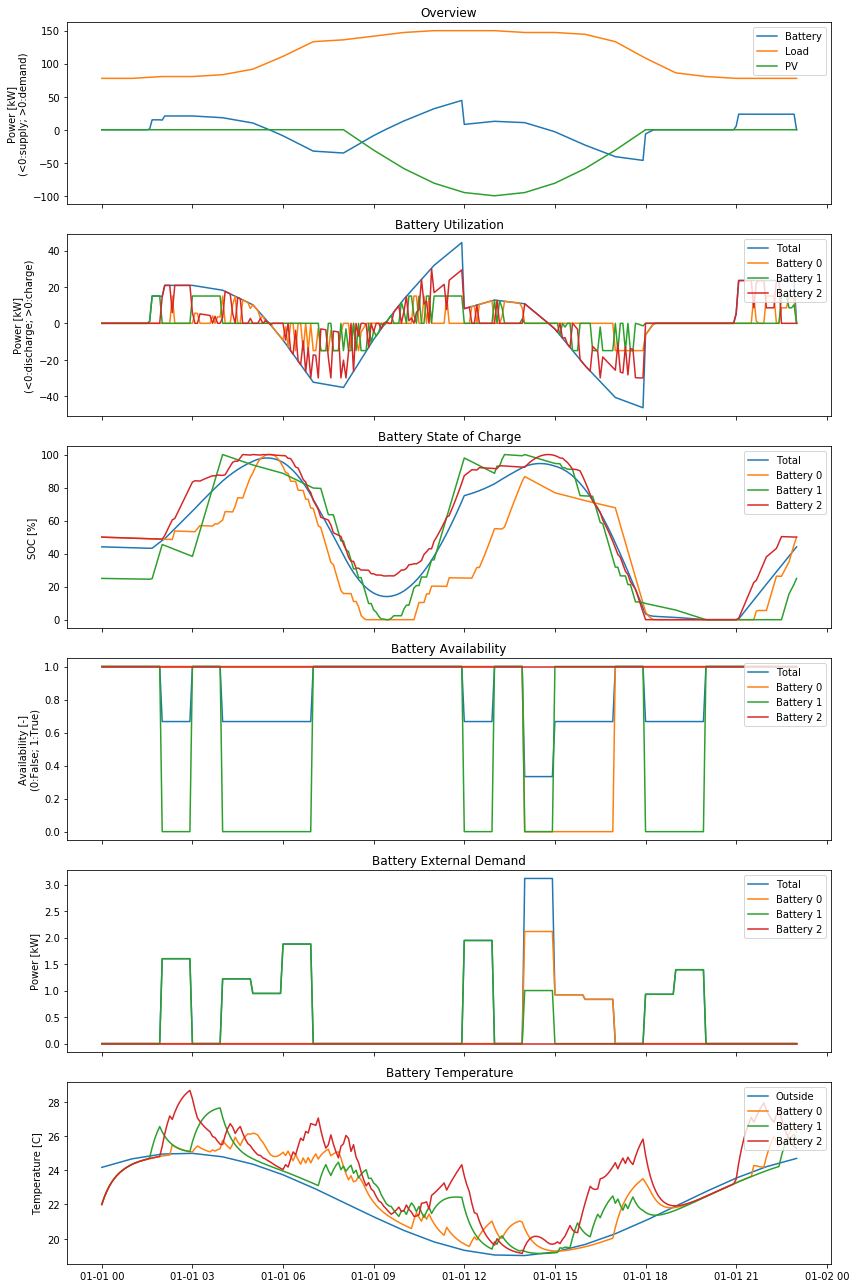

In [95]:
plot_battery1(df, model)

[]

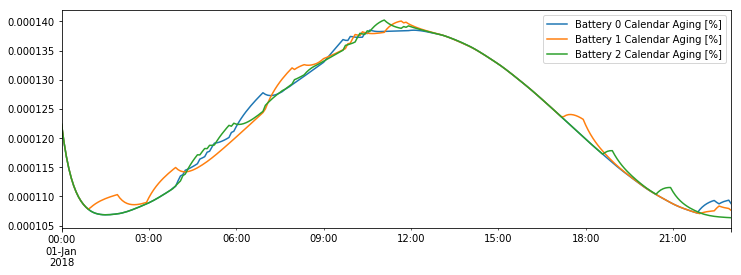

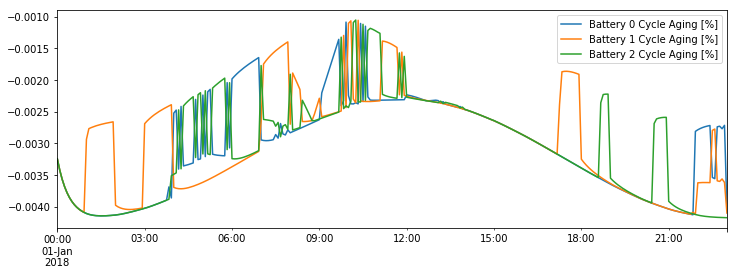

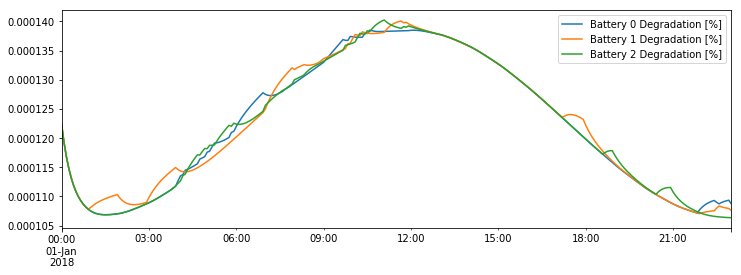

In [17]:
(df[['Battery {!s} Calendar Aging [%]'.format(i) for i in range(parameter['battery']['count'])]]).plot(figsize=(12,4))
plt.plot()
(df[['Battery {!s} Cycle Aging [%]'.format(i) for i in range(parameter['battery']['count'])]]).plot(figsize=(12,4))
plt.plot()
(df[['Battery {!s} Degradation [%]'.format(i) for i in range(parameter['battery']['count'])]]).plot(figsize=(12,4))
plt.plot()

In [18]:
scale_ts_to_year = 24/23 * 365
print('Battery Degradation per Year in [%]')
print((df[['Battery {!s} Calendar Aging [%]'.format(i) for i in range(parameter['battery']['count'])]]).sum() * scale_ts_to_year)
print((df[['Battery {!s} Degradation [%]'.format(i) for i in range(parameter['battery']['count'])]]).sum() * scale_ts_to_year)

Battery Degradation per Year in [%]
Battery 0 Calendar Aging [%]    12.912765
Battery 1 Calendar Aging [%]    12.938366
Battery 2 Calendar Aging [%]    12.914870
dtype: float64
Battery 0 Degradation [%]    12.912765
Battery 1 Degradation [%]    12.938366
Battery 2 Degradation [%]    12.914870
dtype: float64


### CEC CPR Report

In [12]:
parameter['objective']['weight_degradation'] = 0
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))

NameError: name 'parameter' is not defined

In [13]:
parameter['objective']['weight_degradation'] = 0
parameter['battery']['soc_initial'] = [0] * 3
parameter['battery']['soc_final'] = [0] * 3
parameter['battery']['self_discharging'] = [0] * 3 
for b in range(parameter['battery']['count']):
    data['battery_{!s}_avail'.format(b)] = 0
    data['battery_{!s}_demand'.format(b)] = 0
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))

NameError: name 'parameter' is not defined

In [14]:
parameter['objective']['weight_degradation'] = 1
parameter['battery']['soc_initial'] = [0] * 3
parameter['battery']['soc_final'] = [0] * 3
parameter['battery']['self_discharging'] = [0] * 3 
for b in range(parameter['battery']['count']):
    data['battery_{!s}_avail'.format(b)] = 0
    data['battery_{!s}_demand'.format(b)] = 0
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))

NameError: name 'parameter' is not defined

In [91]:
parameter['objective']['weight_degradation'] = 1
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))

Attention, excluded cycle aging model!
Solver			CBC
Duration [s]		5.45
Objective [$]		10820.92		3836.32 (Total Cost)
Cost [$]		6771.53 (Energy)	3610.6 (Demand)		438.79 (Degradation)
Revenue [$]		0.0 (Export)		0.0 (Regulation)



# NOTE: No impact of degradation due to calendar again only! FIX!

# Test it!

In [15]:
def standard_report(res):
    duration, objective, df, model, result, termination = res
    output = ''
    output += 'Solver\t\t\t{!s}\n'.format(result['Solver'][0]['Message'].split(' ')[0])
    output += 'Duration [s]\t\t{!s}\n'.format(round(duration, 2))
    output += 'Objective [$]\t\t{!s}\t\t{!s} (Total Cost)\n'.format(round(objective, 2), round(model.total_cost.value, 2))   
    output += 'Cost [$]\t\t{!s} (Energy)\t{!s} (Demand)\t\t{!s} (Degradation)\n' \
                .format(round(model.sum_energy_cost.value* parameter['objective']['weight_energy'], 2), \
                        round(model.sum_demand_cost.value * parameter['objective']['weight_demand'], 2), \
                        round(model.sum_degradation_cost.value * parameter['objective']['weight_degradation'], 2))
    output += 'Revenue [$]\t\t{!s} (Export)\t\t{!s} (Regulation)\n' \
                .format(round(model.sum_export_revenue.value * parameter['objective']['weight_export'], 2), \
                        round(model.sum_regulation_revenue.value * parameter['objective']['weight_regulation'], 2))
    #output += str(round(df[['Reg Revenue [$]']].sum().values[0], 2))
    return output

### Example Data

In [140]:
# Specify parameter
def dafault_parameter():
    parameter = {}
    parameter['tariff'] = {}
    if False:
        parameter['tariff']['energy'] = {0:0.2,1:0.3,2:0.5} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
        parameter['tariff']['demand'] = {0:1,1:2,2:3} # $/kW for periods 0-offpeak, 1-midpeak, 2-onpeak
        parameter['tariff']['demand_coincident'] = 0.5 # $/kW for coincident
        parameter['tariff']['export'] = {0:0} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
    else:
        parameter['tariff']['energy'] = {0:0.08671, 1:0.11613, 2:0.16055} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
        parameter['tariff']['demand'] = {0:0, 1:5.40, 2:19.65} # $/kW for periods 0-offpeak, 1-midpeak, 2-onpeak
        parameter['tariff']['demand_coincident'] = 17.74 # $/kW for coincident
        parameter['tariff']['export'] = {0:0.01} # $/kWh for periods 0-offpeak, 1-midpeak, 2-onpeak
    parameter['tariff']['regulation_minbid'] = 0 # kW Minimum bid for regulation
    #parameter['tariff']['regulation_min'] = 0 # minimum bid for regulation (positive value) FIXME this must be 0!
    parameter['battery'] = {}
    parameter['battery']['count'] = 3 # Number of batteries
    # Flexgrid
    parameter['battery']['capacity'] = [6.4, 6.4, 6.4] # kWh
    parameter['battery']['power'] = [3.3, 3.3, 3.3] # kW
    # Leafs
    #parameter['battery']['capacity'] = [20, 20, 20] # kWh
    #parameter['battery']['power'] = [15, 15, 15] # kW
    parameter['battery']['soc_initial'] = [0, 0.25, 0.5] # State of Charge initially in 1
    parameter['battery']['soc_final'] = [0.5, 0.25, 0] # State of Charge finally in 1
    parameter['battery']['soc_min'] = [0, 0, 0] # State of Charge minimum in 1
    parameter['battery']['soc_max'] = [1, 1, 1] # State of Charge maximum in 1
    parameter['battery']['efficiency_charging'] = [0.96, 0.96, 0.96] # Charging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['efficiency_discharging'] = [0.96, 0.96, 0.96] # Discharging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['self_discharging'] = [0.3, 0.3, 0.3] # % of SoC per 24 hours
    parameter['battery']['temperature_initial'] = [22.0, 22.0, 22.0] # Initial temperature in C
    parameter['battery']['thermal_R'] = [0.01, 0.01, 0.01] # Themal resistance of batteries in K/W
    parameter['battery']['thermal_C'] = [1e5, 1e5, 1e5] # Themal capacitance of batteries in J/K
    parameter['battery']['nominal_V'] = [400, 400, 400] # Nominal valtage of battery in V
    parameter['battery']['degradation_replacementcost'] = [6e3, 6e3, 6e3] # Replacementcost of the batteryin $
    parameter['battery']['degradation_endoflife'] = [80, 80, 80] # End of life threshold in %
    parameter['site'] = {}
    parameter['site']['customer'] = 'Commercial' # Type of customer [commercial or none]; decides if demand charge
    parameter['site']['regulation'] = False # Enables or disables the regulation bidding
    parameter['site']['regulation_reserved'] = False # Flag to reserve capacity in battery (disables site regulation!)
    parameter['site']['import_max'] = 1000 # kW
    parameter['site']['export_max'] = 20 # kW
    parameter['site']['demand_periods_prev'] = {0:0,1:0,2:0} # kW peak previously set for periods 0-offpeak, 1-midpeak, 2-onpeak
    parameter['site']['demand_coincident_prev'] = 0 # kW peak previously set for coincident
    parameter['controller'] = {}
    parameter['controller']['timestep'] = 60*60 # Controller timestep in seconds
    parameter['objective'] = {}
    parameter['objective']['weight_energy'] = 1 # Weight of tariff (energy) cost in objective
    parameter['objective']['weight_demand'] = 1 # Weight of tariff (demand) cost in objective
    parameter['objective']['weight_export'] = 1 # Weight of revenue (export) in objective
    parameter['objective']['weight_regulation'] = 1 # Weight of revenue (regulation) in objective
    parameter['objective']['weight_degradation'] = 1 # Weight of battery degradation cost in objective
    return parameter

def dafault_parameter_laafb_report1():
    parameter = dafault_parameter()
    
    # Overwrite battery with 2x Leaf, 1x Stationary
    parameter['battery'] = {}
    parameter['battery']['count'] = 3 # Number of batteries
    parameter['battery']['capacity'] = [24, 24, 54] # kWh
    parameter['battery']['power'] = [15, 15, 30] # kW
    parameter['battery']['soc_initial'] = [0.5, 0.25, 0.5] # State of Charge initially in 1
    parameter['battery']['soc_final'] = [0.5, 0.25, 0.5] # State of Charge finally in 1
    parameter['battery']['soc_min'] = [0, 0, 0] # State of Charge minimum in 1
    parameter['battery']['soc_max'] = [1, 1, 1] # State of Charge maximum in 1
    parameter['battery']['efficiency_charging'] = [0.96, 0.96, 0.96] # Charging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['efficiency_discharging'] = [0.96, 0.96, 0.96] # Discharging efficiency [0-1]; Tesla: 0.96
    parameter['battery']['self_discharging'] = [0.3, 0.3, 0.3] # % of SoC per 24 hours
    parameter['battery']['temperature_initial'] = [22.0, 22.0, 22.0] # Initial temperature in C
    parameter['battery']['thermal_R'] = [0.01, 0.01, 0.01] # Themal resistance of batteries in K/W
    parameter['battery']['thermal_C'] = [1e5, 1e5, 1e5] # Themal capacitance of batteries in J/K
    parameter['battery']['nominal_V'] = [400, 400, 400] # Nominal valtage of battery in V
    parameter['battery']['degradation_replacementcost'] = [6e3, 6e3, 6e3] # Replacementcost of the batteryin $
    parameter['battery']['degradation_endoflife'] = [80, 80, 80] # End of life threshold in %
    return parameter   
    
#parameter = dafault_parameter()
parameter = dafault_parameter_laafb_report1()

# Change weights for 1 month (30 days)
parameter['objective']['weight_energy'] = 30 # Weight of tariff (energy) cost in objective
parameter['objective']['weight_demand'] = 1 # Weight of tariff (demand) cost in objective
parameter['objective']['weight_export'] = 0 # Weight of revenue (export) in objective
parameter['objective']['weight_regulation'] = 0 # Weight of revenue (regulation) in objective
parameter['objective']['weight_degradation'] = 30 # Weight of battery degradation cost in objective
    

In [141]:
def example_inputs(load='Flexlab', scale_load=4, scale_pv=4):
    #scale = 1
    #scale = 30 
    if load == 'Flexlab':
        data = pd.read_csv(os.path.join(root_dir, 'ExampleData', 'Flexlab.csv'))
        data.index = pd.to_datetime(data['Date/Time'].apply(lambda x: '2018/'+x[1:6]+' '+'{:2d}'.format(int(x[8:10])-1)+x[10::]))
        del data.index.name
        data = data[['FLEXLAB-X3-ZONEA:Zone Air Heat Balance System Air Transfer Rate [W](Hourly)']]
        data.columns = ['load_demand']
        #data['load_demand'] = data['load_demand'].mask(data['load_demand']<0, data['load_demand']*-1/3.5) / 1000.
        data['load_demand'] = data['load_demand'].mask(data['load_demand']<0, data['load_demand']*-1/2.) / 1000.
        # Use only 1 day
        data = data.iloc[0:24]
        data['load_demand'] = data['load_demand']/data['load_demand'].max()
    elif load =='B90':
        data = pd.DataFrame(index=pd.date_range(start='2019-01-01 00:00', end='2019-01-01 23:00', freq='H'))
        data['load_demand'] = [2.8,  2.8,  2.9,  2.9,  3. ,  3.3,  4. ,  4.8,  4.9,  5.1,  5.3,
                               5.4,  5.4,  5.4,  5.3,  5.3,  5.2,  4.8,  3.9,  3.1,  2.9,  2.8,
                               2.8,  2.8]
        data['load_demand'] = data['load_demand']/data['load_demand'].max()
    # Scale Load data
    data['load_demand'] = data['load_demand'] * scale_load
    # Mode of OAT
    data['oat'] = np.sin(data.index.astype(int)/(1e12*np.pi*4))*3 + 22
    data['tariff_energy_map'] = 0
    data['tariff_energy_map'] = data['tariff_energy_map'].mask((data.index.hour>=8) & (data.index.hour<22), 1)
    data['tariff_energy_map'] = data['tariff_energy_map'].mask((data.index.hour>=12) & (data.index.hour<18), 2)
    data['tariff_power_map'] = data['tariff_energy_map'] # Apply same periods to demand charge
    data['tariff_energy_export_map'] = 0
    data['generation_pv'] = 0
    data.loc[data.index[8:19], 'generation_pv'] = [np.sin(i/(10/(np.pi))) for i in range(11)]
    data['generation_pv'] = data['generation_pv'] * scale_pv
    data['tariff_regup'] = data['tariff_power_map'] * 0.05 + 0.01
    data['tariff_regdn'] = data['tariff_power_map'] * 0.01 + 0.01
    data['battery_reg'] = 0
    for b in range(parameter['battery']['count']):
        np.random.seed(b)
        data['battery_{!s}_avail'.format(b)] = np.random.choice(2, len(data.index), p=[0.25, 0.75])
        np.random.seed(b+15)
        data['battery_{!s}_demand'.format(b)] = -1 * (data['battery_{!s}_avail'.format(b)] - 1) \
                                                * np.random.uniform(low=0.5, high=2.5, size=len(data.index))
    #data['battery_reg'].iloc[5:10] = -1
    data['date_time'] = data.index
    # Resample
    if True:
        data = data.resample('5T').asfreq()
        for c in data.columns:
            if c in ['load_demand','generation_pv','oat']:
                data[c] = data[c].interpolate()
            else:
                data[c] = data[c].ffill()
        data = data.loc['2019-01-01 00:00:00':'2019-01-02 00:00:00']
    else:
        data = data.loc['2019-01-01 00:00:00':'2019-01-02 00:00:00']
    #data.index = data.index.astype(int)/1000000000
    #data = data.reset_index(drop=True)
    return data

def example_inputs_laafb_report1():
    data = example_inputs(load='B90', scale_load=150, scale_pv=100)
    # Set tower as stationary
    b = 2
    data['battery_{!s}_avail'.format(b)] = 1
    data['battery_{!s}_demand'.format(b)] = 0
    return data
    
#data = example_inputs()
data = example_inputs_laafb_report1()

In [142]:
data

,load_demand,oat,tariff_energy_map,tariff_power_map,tariff_energy_export_map,generation_pv,tariff_regup,tariff_regdn,battery_reg,battery_0_avail,battery_0_demand,battery_1_avail,battery_1_demand,battery_2_avail,battery_2_demand,date_time
2019-01-01 00:00:00,77.777778,24.166351,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:05:00,77.777778,24.207863,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:10:00,77.777778,24.249375,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:15:00,77.777778,24.290887,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:20:00,77.777778,24.332399,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:25:00,77.777778,24.373911,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:30:00,77.777778,24.415423,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:35:00,77.777778,24.456935,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:40:00,77.777778,24.498447,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00
2019-01-01 00:45:00,77.777778,24.539959,0.0,0.0,0.0,0.0,0.01,0.01,0.0,1.0,0.0,1.0,0.000000,1,0,2019-01-01 00:00:00


# Test with different solver

In [ ]:
solvers = ['cbc','ipopt','couenne']
for solver in solvers:
    smartDER = DOPER(model=SmartInverter_model,
                     parameter=parameter,
                     solver_path=get_solver(solver, solver_dir=solver_dir),
                     pyomo_to_pandas=pyomo_to_pandas)
    res = smartDER.do_optimization(data)
    duration, objective, df, model, result, termination = res
    print (standard_report(res))

In [ ]:
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_pathget_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data.iloc[0:12])
duration, objective, df, model, result, termination = res
plot_standard1(df, plot_times=False)

In [ ]:
#result.write()

In [ ]:
model.pprint()

# Test new Optimization module (with variable timestep)

In [ ]:
# Example INPUT
data = pd.read_csv(os.path.join(root_dir, 'ExampleData', 'Flexlab.csv'))
data.index = pd.to_datetime(data['Date/Time'].apply(lambda x: '2018/'+x[1:6]+' '+'{:2d}'.format(int(x[8:10])-1)+x[10::]))
del data.index.name
data = data[['FLEXLAB-X3-ZONEA:Zone Air Heat Balance System Air Transfer Rate [W](Hourly)']]
data.columns = ['load_demand']
data['load_demand'] = data['load_demand'].mask(data['load_demand']<0, data['load_demand']*-1/3.5) / 1000.
# Use only 1 day
data = data.iloc[0:24]
# Scale Load data
data['load_demand'] = data['load_demand'] * 4
data['tariff_energy_map'] = 0
data['tariff_energy_map'] = data['tariff_energy_map'].mask((data.index.hour>=8) & (data.index.hour<22), 1)
data['tariff_energy_map'] = data['tariff_energy_map'].mask((data.index.hour>=12) & (data.index.hour<18), 2)
data['tariff_power_map'] = data['tariff_energy_map'] # Apply same periods to demand charge
data['tariff_energy_export_map'] = 0
data['generation_pv'] = 0
data['generation_pv'].iloc[10:16] = [np.sin(i/(5/(np.pi))) * 4 for i in range(6)]
data['tariff_regup'] = data['tariff_power_map'] * 0.05 + 0.01
data['tariff_regdn'] = data['tariff_power_map'] * 0.01 + 0.01
data['date_time'] = data.index
#data = data.reset_index(drop=True)
#data

# Test the Script

In [ ]:
#from SlowActingControlv10 import do_optimization, plot_standard1

parameter['site']['regulation'] = False
parameter['battery']['soc_initial'] = 0
parameter['battery']['soc_final'] = 0
parameter['battery']['soc_min'] = 0
parameter['battery']['soc_max'] = 1

In [ ]:
print ('Resampled to 5 minute (no Regulation)')
data_rs = data.resample('5T').ffill()
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data_rs.loc['2018-01-01 00:00:00':'2018-01-01 22:55:00'])
duration, objective, df, model, result, termination = res
print (standard_report(res))
plot_standard1(df)

In [ ]:
print ('Basecase with hourly timestep (no Regulation)')
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data.loc['2018-01-01 00:00:00':'2018-01-01 22:00:00'])
duration, objective, df, model, result, termination = res
print (standard_report(res))
plot_standard1(df)

### Test with DefaultConfiguration function

In [ ]:
from DefaultConfiguration import get_parameter_slowacting_flexgrid, get_input_example2

parameter = get_parameter_slowacting_flexgrid()
data = get_input_example2()

print ('Resampled to 5 minute (no Regulation)')
data_rs = data.resample('5T').ffill()
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data_rs.loc['2018-01-01 00:00:00':'2018-01-01 22:55:00'])
duration, objective, df, model, result, termination = res
print (standard_report(res))
plot_standard1(df)

In [ ]:
get_parameter_slowacting_flexgrid()

# Test Major and Minor

In [ ]:
parameter = get_parameter_slowacting_flexgrid()
data = get_input_example2()
print ('Running Major')
parameter['site']['regulation'] = True
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))
df[['Reg Up [kW]','Reg Dn [kW]']].plot(figsize=(16,3))
plt.show()
#plot_standard1(df)

print ('Running Minor (hourly)')
data['battery_reg'] = (-1*df['Reg Up [kW]'] + df['Reg Dn [kW]']) * 0.95
#print data['battery_reg']
parameter['site']['regulation'] = False
parameter['site']['regulation_reserved'] = True
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
print (standard_report(res))
df[['Reg Up [kW]','Reg Dn [kW]']].plot(figsize=(16,3))
plt.show()
#plot_standard1(df)


print ('Running Minor (5-min)')
parameter['site']['regulation'] = False
parameter['site']['regulation_reserved'] = True
data_rs = data.resample('5T').ffill()
smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data_rs)
duration, objective, df, model, result, termination = res
print (standard_report(res))
df[['Reg Up [kW]','Reg Dn [kW]']].plot(figsize=(16,3))
plt.show()
#plot_standard1(df)

# Test battery self-discharge

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,3))
ax2 = ax1.twinx()
p = ax1.plot(df['Battery Energy [kWh]'], 'g-')
p += ax2.plot(df['Battery Self Discharge [kW]'], 'b-')
plt.legend(p, [l.get_label() for l in p])
plt.show()

print ('Self-discharge @ 6.4 kWh with 0.3 %/24h = 0.08 kW')

# RC Thermal Model

In [ ]:
parameter = dafault_parameter()
data = example_inputs()

# Fix Outside tmeperature
data['oat'] = 22

smartDER = DOPER(model=SmartInverter_model,
                 parameter=parameter,
                 solver_path=get_solver('cbc', solver_dir=solver_dir),
                 pyomo_to_pandas=pyomo_to_pandas)
res = smartDER.do_optimization(data)
duration, objective, df, model, result, termination = res
#print (standard_report(res))

df[['Battery 1 Power [kW]']].plot(figsize=(12,2))
df[['Battery 1 Temperature [C]']].plot(figsize=(12,2))
plt.plot()

In [ ]:
# Refer to LAAFB/optimization/RC Model.ipynb
print('Battery loss: {:.0f} W (should be 131 W)'.format(df[['Battery 1 Power [kW]']] \
                                                 .loc['2018-01-01 01:00':'2018-01-01 01:55'].mean().values[0] \
                                                 * (1-parameter['battery']['efficiency_charging'][0]) * 1000))
predicted = 22.6 # Refer to RC Model.ipynb
measured = round(df[['Battery 1 Temperature [C]']].loc['2018-01-01 01:55'].values[0], 1)
print('Battery Temperature predicted is {!s} C and MPC is {!s}'.format(predicted, measured))
print('Passed? {!s}'.format(predicted==measured))

# Battery Degradation Model (Wang)

In [ ]:
from BatteryDegradationModel import Wang_model

In [ ]:
#Wang_model(T, C, E, days, mode='Wang', temp_range=[0,50])
Wang_model(10, 0, 0, 500)